# Roosevelt National Forest of northern Colorado Competition

In this experiment we will apply some ensemble methods based on Decisión Trees to find out a good classifier for the problem

Ensemble Method: XGB

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

%matplotlib inline

In [2]:
# Global parameters
#root folder
root_folder='..\..'
#data_folder='.'
data_folder_name='Datasets/RooseveltForest'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH


## Data Preprocessing

In [3]:
# Reading the csv file with the whole dataset
train_data = pd.read_csv(train_path+'\\train.csv', sep=',', header=0, index_col=0)
# Train data, erasing label column
#train_data = data.drop('Cover_Type', axis=1)

#train_label = data[['Cover_Type']]
#test_data = pd.read_csv('test_values.csv', sep=',', header=0,index_col=0)


In [4]:
# Define some groups of columns based on  type
var_numeric = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
                'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm',
                'Horizontal_Distance_To_Fire_Points']
# There are no categoric variables to transfomr
var_categoric = []

# Numerical columns with missing values
# In our first approach, no missing values to consider
columns_nan=[]

### Feature engineering and selection

In [5]:
#Defining some relevant group of columns
# Columns to be ingored for classification
# Soil Type 7,8, 15 y 25
columns_to_ignore = ['Soil_Type7','Soil_Type8','Soil_Type15','Soil_Type25']

columns_unselect=[]
# Horizontal to roadways and to Fire poins are very simila recpect to arget variable so lets drop horizontal to roadways
#columns_unselect+=['Horizontal_Distance_To_Roadways']
# Horizontal and vertical to hidrology are correlated, lets drop vertical
#columns_unselect+=['Vertical_Distance_To_Hydrology']
# Drop soil types where the number of rows are very low: 9, 21, 27, 28, 36 
#columns_unselect=['Soil_Type9','Soil_Type21','Soil_Type27','Soil_Type28','Soil_Type36']

# We have to analyze outliers

In [6]:
# Delete non relevant columns
train_df= train_data.drop(columns_to_ignore+columns_unselect, axis=1)
train_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
6,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
7,2606,45,7,270,5,633,222,225,138,6256,...,0,0,0,0,0,0,0,0,0,5
8,2605,49,4,234,7,573,222,230,144,6228,...,0,0,0,0,0,0,0,0,0,5
9,2617,45,9,240,56,666,223,221,133,6244,...,0,0,0,0,0,0,0,0,0,5


## Building and training a XGBoost model 

Guide for Parameter Tunning: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

The implementation is taken from this url, very interesting for those looking for some clues about hyperparameter tunning for XGBoost models. 

In [7]:
#Import libraries:
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
#from xgboost.sklearn import XGBClassifier
#from sklearn import cross_validation
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search


In [8]:
target = 'Cover_Type'
#IDcol = 'ID'

In [9]:
print(train_df[target].unique())
# Need to transform target values in the range 0..num_classes-1
y_replace={1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6}
train_df[target].replace(y_replace,inplace=True)
print(train_df[target].unique())
num_classes = len(train_df[target].unique())
print('Num Classes: ',num_classes)

[5 2 1 7 3 6 4]
[4 1 0 6 2 5 3]
Num Classes:  7


In [10]:
print('Df Shape: ',train_df.values.shape)
X= train_df.values[:,:-1]
y= train_df.values[:,-1]
print ('X: ',X.shape,' y: ',y.shape)

Df Shape:  (15120, 51)
X:  (15120, 50)  y:  (15120,)


In [11]:
def modelfit(alg, x_train, y_train, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    print('N estimators = ', cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train, eval_metric='merror')

    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
#    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
#    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#    feat_imp.plot(kind='bar', title='Feature Importances')
    plot_importance(alg, max_num_features = 30)
    plt.ylabel('Feature Importance Score')
    plt.show()

In [62]:
def modelfit(alg, x_train, y_train, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='merror', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    print('N estimators = ', cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='merror')
        

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
#    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
#    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#    feat_imp.plot(kind='bar', title='Feature Importances')
    plot_importance(alg, max_num_features = 30)
    plt.ylabel('Feature Importance Score')
    plt.show()
#    plt.ylabel('Feature Importance Score')

You can observed that we use cross-validation for a given learning_rate (and some others parameters) and the best configuration of n_estimatores is used for the traiing the XGBoost model. 

N estimators =  414

Model Report
Accuracy : 0.8915


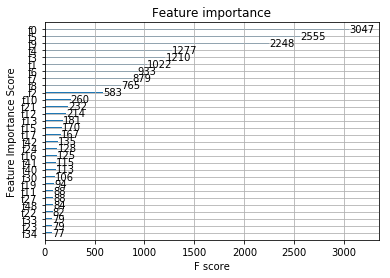

In [20]:
#Choose all predictors except target & IDcols
# Get the name of the features 
#predictors = [x for x in train_data.columns if x not in [target]]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=7,
 job=-1,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, X, y, target, cv_folds=5, early_stopping_rounds=10)

Now Lets tune max_depth and min_child_weight. Choose values for those parameters based on cumputing power and experience
Previous parameters:

 learning_rate =0.1,
 n_estimators=500,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=7,
 nthread=4,
 scale_pos_weight=1

In [21]:
#Choose all predictors except target & IDcols
# Get the name of the features 
#predictors = [x for x in train_data.columns if x not in [target]]

param_test1 = {
 'max_depth':range(2,7,2),
 'min_child_weight':range(1,7,3)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', num_class=7, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X,y)
#gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, num_class=7, objective='multi:softmax',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=None, subsample=0.8, verbosity=1),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': range(2, 7, 2), 'min_child_weight': range(1, 7, 3)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [22]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 6, 'min_child_weight': 1}, 0.7822751322751322)

In [23]:
gsearch1.cv_results_ 

C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([148.05925794, 153.52397742, 234.63958154, 224.52910328,
        316.26411915, 258.56490064]),
 'mean_score_time': array([0.7039001 , 0.7111702 , 1.30573654, 1.21638441, 1.81586738,
        1.29522734]),
 'mean_test_score': array([0.71997354, 0.72037037, 0.76574074, 0.76335979, 0.78227513,
        0.77731481]),
 'mean_train_score': array([0.83417659, 0.83258929, 0.96089616, 0.95213294, 0.99983466,
        0.99775132]),
 'param_max_depth': masked_array(data=[2, 2, 4, 4, 6, 6],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 4, 1, 4, 1, 4],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2, 'min_child_weight': 1},
  {'max_depth': 2, 'min_child_weight': 4},
  {'max_depth': 4, 'min_child_weight': 1},
  {'max_depth': 4, 'min_child_weight': 4},
  {'max_depth': 6,

In [67]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.3.


Tune gamma parameter based on the previous best parameters 

In [24]:
param_test3 = {
 'gamma':[0.1,0.3,0.5]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=400, max_depth=6,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', num_class=7, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='accuracy',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X,y)
gsearch3.best_params_, gsearch3.best_score_


({'gamma': 0.1}, 0.7838624338624338)

Recaibreate the number of estimators based on the optimized parameters we have already found

N estimators =  245

Model Report
Accuracy : 0.9805


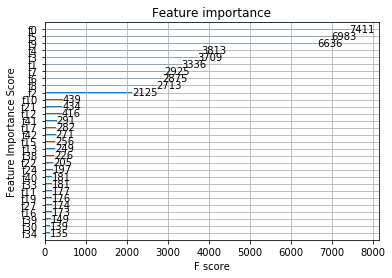

In [25]:
#Choose all predictors except target & IDcols
# Get the name of the features 
#predictors = [x for x in train_data.columns if x not in [target]]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=500,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 num_class=7,
 job=-1,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, X, y, target, cv_folds=5, early_stopping_rounds=10)

Tune subsample and colsample_bytree

In [27]:
param_test4 = {
 'subsample':[0.6,0.8,1.0],
 'colsample_bytree':[0.6,0.8,1.0]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=245, max_depth=6,
 min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', num_class=7, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='accuracy',n_jobs=-1,iid=False, cv=5)

gsearch4.fit(X,y)

gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 1.0, 'subsample': 0.6}, 0.7792989417989418)

Tuning Regularization Parameters

In [12]:
param_test6 = {
 'reg_alpha':[1e-3, 0.1, 1]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=245, max_depth=6,
 min_child_weight=1, gamma=0.1, subsample=0.6, colsample_bytree=1.0,
 objective= 'multi:softmax', num_class=7, scale_pos_weight=1, seed=27), 
 param_grid = param_test6, scoring='accuracy',n_jobs=-1,iid=False, cv=5)

gsearch6.fit(X,y)

gsearch6.best_params_, gsearch6.best_score_


({'reg_alpha': 0.001}, 0.7783068783068783)

Finally we will reduce the learning rate and increase the number of iterators to fine tune the model with all previous parameters 

N estimators =  251

Model Report
Accuracy : 0.9848


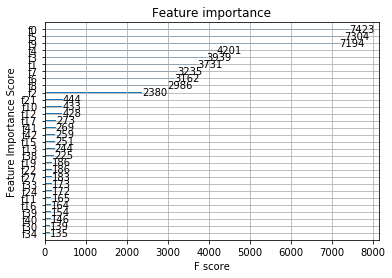

In [14]:
#Choose all predictors except target & IDcols
# Get the name of the features 
#predictors = [x for x in train_data.columns if x not in [target]]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=600,
 max_depth=6,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.6,
 colsample_bytree=0.8,
 reg_alpha=0.001,
 objective= 'multi:softmax',
 num_class=7,
 job=-1,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb1, X, y, target, cv_folds=5, early_stopping_rounds=10)